In [1]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

import seaborn as sns

#### MCMC
* King Markov Example
* There is a king and he visits islands (7) with varying sizes, and so he goes to the islands proportionally often to their populations

In [2]:
# populations of islands
p_1 = 100
p_2 = 120
p_3 = 150
p_4 = 200
p_5 = 260
p_6 = 300 
p_7 = 400

coin_flip_p = 1/2

In [3]:
coin_flip = stats.bernoulli.rvs(p=0.5)
coin_flip == 1

True

In [4]:
populations = [p_1, p_2, p_3, p_4, p_5, p_6, p_7]
num_islands = len(populations)

In [5]:
num_islands

7

In [6]:
islands_visited = []

In [7]:
def simulate_king_markov_visits(starting_island=4, number_of_visits = 100):
    current_island = starting_island

    for i in range(number_of_visits):
        print(f"We are on island {current_island}")
        
        coin_flip = stats.bernoulli.rvs(p=0.5)
        
        if coin_flip == 1:
            print("The coin landed at 1")
            proposal_island = current_island + 1
            if proposal_island > num_islands:
                proposal_island = 1
            print(f"We are maybe going right! To island {proposal_island}")
        else:
            print("The coint landed at 0")
            proposal_island = current_island -1
            if proposal_island < 1:
                proposal_island = 7
            print(f"We are maybe going left! To island {proposal_island}")
        
        population_proposal_island = populations[proposal_island-1]
        population_current_island = populations[current_island-1]
        
        if population_proposal_island/population_current_island > 1:
            p_of_move = 1
        else:
            p_of_move = population_proposal_island/population_current_island
                    
        move_to_proposal = stats.bernoulli.rvs(p=p_of_move)
        
        if move_to_proposal == 1:
            print(f"Moving to island {proposal_island}. The probability of this move was {p_of_move}")
            current_island = proposal_island
        else:
            print(f'Staying on island {current_island}. The probability of this stay was {1-p_of_move}')

        islands_visited.append(current_island)    
            
        print("------")

In [8]:
simulate_king_markov_visits(7, 10000)

We are on island 7
The coin landed at 1
We are maybe going right! To island 1
Staying on island 7. The probability of this stay was 0.75
------
We are on island 7
The coin landed at 1
We are maybe going right! To island 1
Moving to island 1. The probability of this move was 0.25
------
We are on island 1
The coint landed at 0
We are maybe going left! To island 7
Moving to island 7. The probability of this move was 1
------
We are on island 7
The coin landed at 1
We are maybe going right! To island 1
Staying on island 7. The probability of this stay was 0.75
------
We are on island 7
The coint landed at 0
We are maybe going left! To island 6
Moving to island 6. The probability of this move was 0.75
------
We are on island 6
The coin landed at 1
We are maybe going right! To island 7
Moving to island 7. The probability of this move was 1
------
We are on island 7
The coin landed at 1
We are maybe going right! To island 1
Moving to island 1. The probability of this move was 0.25
------
We 

In [9]:
island_ids = []
for id_ in range(1, num_islands+1):
    island_ids.append(id_)

In [10]:
island_ids

[1, 2, 3, 4, 5, 6, 7]

In [11]:
sum(populations)

1530

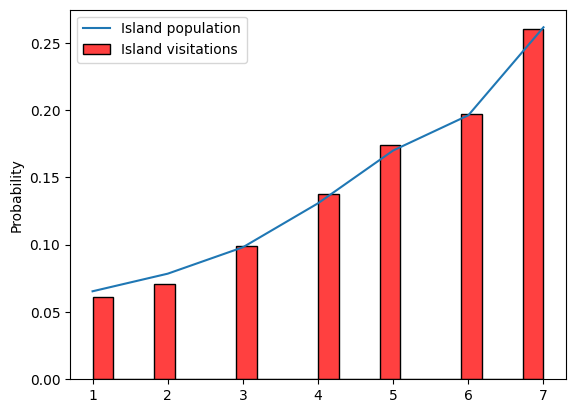

In [22]:
sns.histplot(x=islands_visited, stat="probability", label="Island visitations", color="red")
sns.lineplot(x=island_ids, y=[population/sum(populations) for population in populations], label="Island population")
plt.legend()


* In reality, the usual usecase for drawing samples from a posterior distribution:
    * Islands: *parameter values*
    * Population size: *posterior probability*
    * Visit each parameter value in proportion to its posterior probability

In [26]:
WINES = utils.load_data("Wines2012")
df = WINES

In [27]:
df

judge flight wine  score  wine.amer  judge.amer
0    Jean-M Cardebat  white   A1   10.0          1           0
1    Jean-M Cardebat  white   B1   13.0          1           0
2    Jean-M Cardebat  white   C1   14.0          0           0
3    Jean-M Cardebat  white   D1   15.0          0           0
4    Jean-M Cardebat  white   E1    8.0          1           0
..               ...    ...  ...    ...        ...         ...
175   Francis Schott    red   F2   12.0          1           1
176   Francis Schott    red   G2   15.0          0           1
177   Francis Schott    red   H2   16.0          1           1
178   Francis Schott    red   I2    7.0          1           1
179   Francis Schott    red   J2   17.0          0           1

[180 rows x 6 columns]

#### 1. DRAW DAG (Scientific Model)
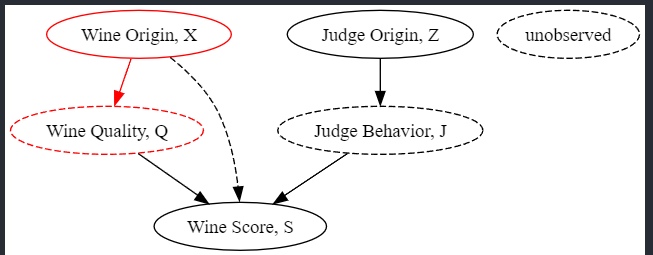

#### 2. Estimand
- Association between **Wine Quality and Wine Origin**
- Stratify by judge (not required) for efficiency

#### Simplest Model

Make sure to start simple

$$
\begin{align*}
S_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= Q_{W[i]} \\
Q_{W[i]} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

Wine quality is an unobserved latent var

In [28]:
# Define & preprocess data / coords

# Continuous, standardized wine scores
SCORES = utils.standardize(WINES.score).values

# Categorical judge ID
JUDGE_ID, JUDGE = pd.factorize(WINES.judge)

# Categorical wine ID
WINE_ID, WINE = pd.factorize(WINES.wine)

# Categorical wine origin
WINE_ORIGIN_ID, WINE_ORIGIN = pd.factorize(["US" if w == 1. else "FR" for w in WINES['wine.amer']], sort=False)


C:\Users\Kuba\AppData\Local\Temp\ipykernel_1332\1827685390.py:13: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  WINE_ORIGIN_ID, WINE_ORIGIN = pd.factorize(["US" if w == 1. else "FR" for w in WINES['wine.amer']], sort=False)


In [37]:
WINE

Index(['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'A2', 'B2',
       'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'J2'],
      dtype='object')

In [43]:
# Fitting simple, wine specific model

with pm.Model(coords={"wine": WINE}) as simple_model:
    
    sigma = pm.Exponential('sigma', 1)
    Q     = pm.Normal("Q", 0, 1, dims="wine")  # Wine ID
    mu    = Q[WINE_ID]
    S     = pm.Normal("S", mu, sigma, observed=SCORES)
    simple_inference = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Q]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [44]:
az.summary(simple_inference)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Q[A1]  0.140  0.319  -0.418    0.770      0.004    0.005    8188.0    2651.0   
Q[B1]  0.273  0.322  -0.308    0.907      0.003    0.004   10104.0    3006.0   
Q[C1] -0.120  0.314  -0.718    0.468      0.003    0.005   10052.0    2791.0   
Q[D1]  0.290  0.318  -0.302    0.876      0.003    0.004    8523.0    2756.0   
Q[E1]  0.087  0.317  -0.497    0.682      0.004    0.005    8002.0    2789.0   
Q[F1] -0.011  0.317  -0.570    0.607      0.003    0.006    9058.0    3050.0   
Q[G1] -0.104  0.315  -0.707    0.486      0.003    0.005    9482.0    3030.0   
Q[H1] -0.219  0.315  -0.841    0.369      0.003    0.004   10259.0    2990.0   
Q[I1] -0.135  0.323  -0.743    0.472      0.003    0.005   10755.0    3147.0   
Q[J1] -0.166  0.307  -0.758    0.384      0.003    0.005    8492.0    2905.0   
Q[A2]  0.104  0.318  -0.523    0.694      0.004    0.005    8240.0    2546.0   
Q[B2]  0.555  0.312  -0.033    1.135      0.003    0.003    9100.0    2760.0   
Q[C2] -0.368  0.316  -0.960    0.224      0.003    0.003    8849.0    2853.0   
Q[D2]  0.271  0.310  -0.309    0.858      0.003    0.004    9569.0    2980.0   
Q[E2]  0.121  0.324  -0.540    0.683      0.003    0.005    9209.0    3044.0   
Q[F2] -0.031  0.315  -0.609    0.550      0.003    0.006   10345.0    2883.0   
Q[G2]  0.008  0.319  -0.618    0.577      0.003    0.005    8765.0    3181.0   
Q[H2] -0.203  0.314  -0.848    0.344      0.003    0.004    8613.0    3148.0   
Q[I2] -0.862  0.317  -1.484   -0.296      0.003    0.003    8947.0    2829.0   
Q[J2]  0.383  0.308  -0.181    0.978      0.003    0.003    8520.0    3276.0   
sigma  0.999  0.056   0.886    1.095      0.001    0.000    6415.0    3089.0   

       r_hat  
Q[A1]   1.00  
Q[B1]   1.01  
Q[C1]   1.00  
Q[D1]   1.00  
Q[E1]   1.00  
Q[F1]   1.00  
Q[G1]   1.00  
Q[H1]   1.00  
Q[I1]   1.00  
Q[J1]   1.00  
Q[A2]   1.00  
Q[B2]   1.00  
Q[C2]   1.00  
Q[D2]   1.00  
Q[E2]   1.00  
Q[F2]   1.00  
Q[G2]   1.00  
Q[H2]   1.00  
Q[I2]   1.00  
Q[J2]   1.00  
sigma   1.00

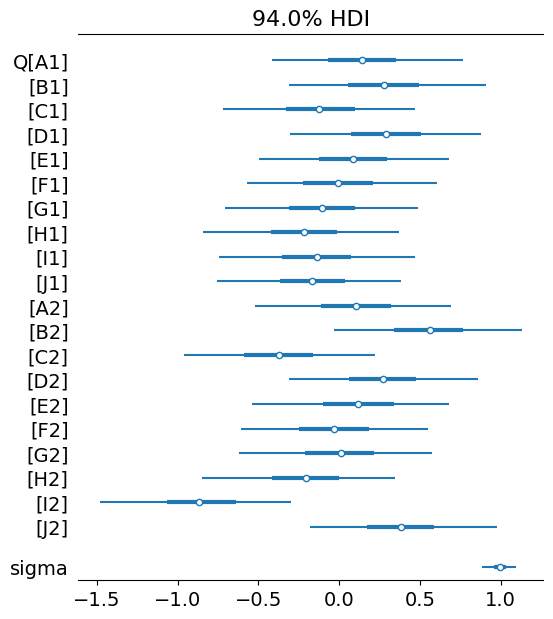

In [45]:
az.plot_forest(simple_inference, combined=True);

Markov chains are complex, so they require some diagnostics:
* Trace plots
* Trace rank plots
* R-hat convergence measure
* Number of effective samples
* Divergent transitions

#### 1. Trace Plots
Look for
- "fuzzy caterpillar"
  - "wandering" paths indicate too small step size (large number of acceptance, but exploring only local space)
  - long periods of same value indicate too large step size (large number of rejections, not exploring space)
- Each param should have similar density across chains
 

c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


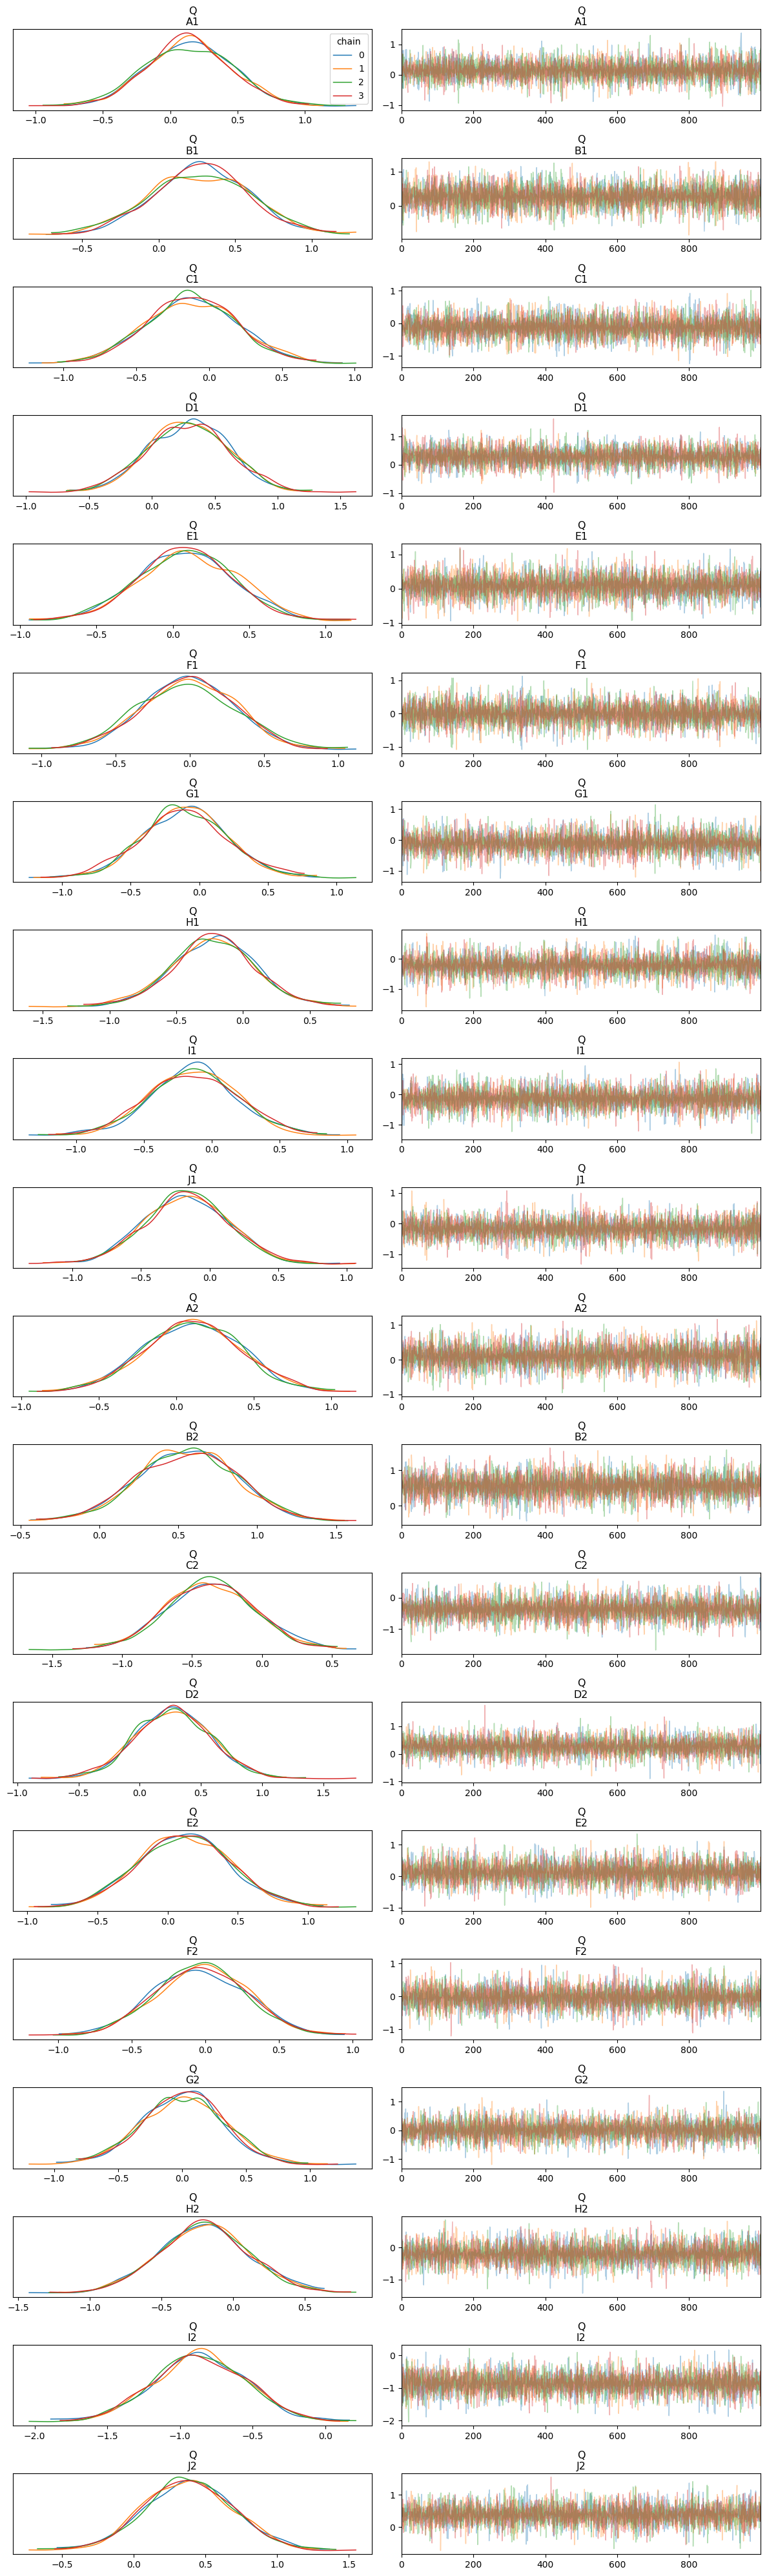

In [46]:
az.plot_trace(simple_inference, compact=False, legend=True);
plt.tight_layout()

It looks good.

> If HMC is sampling correctly, you'll only need a few hundred samples to get a good idea of the shape of the posterior. This is because, under the correct initial conditions and model parameterization, HMC is very efficient.

Bad trace plot examples:

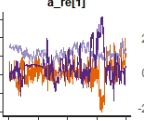
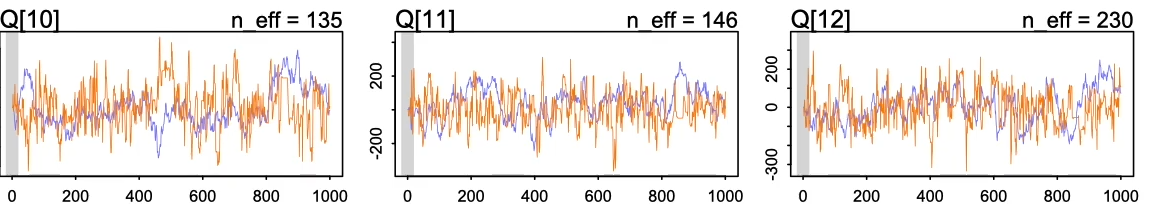

Compact form of traceplots

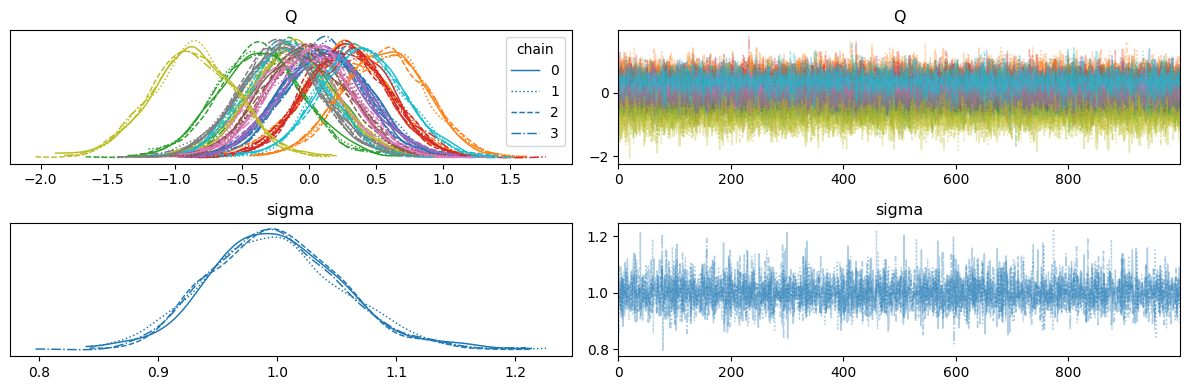

In [48]:
az.plot_trace(simple_inference, compact=True, legend=True);
plt.tight_layout()

#### 2. Trace Rank "Trank" Plots
- Don't want any one chain having largest or smallest rank for extended period of time.
- "jumbled up" is good

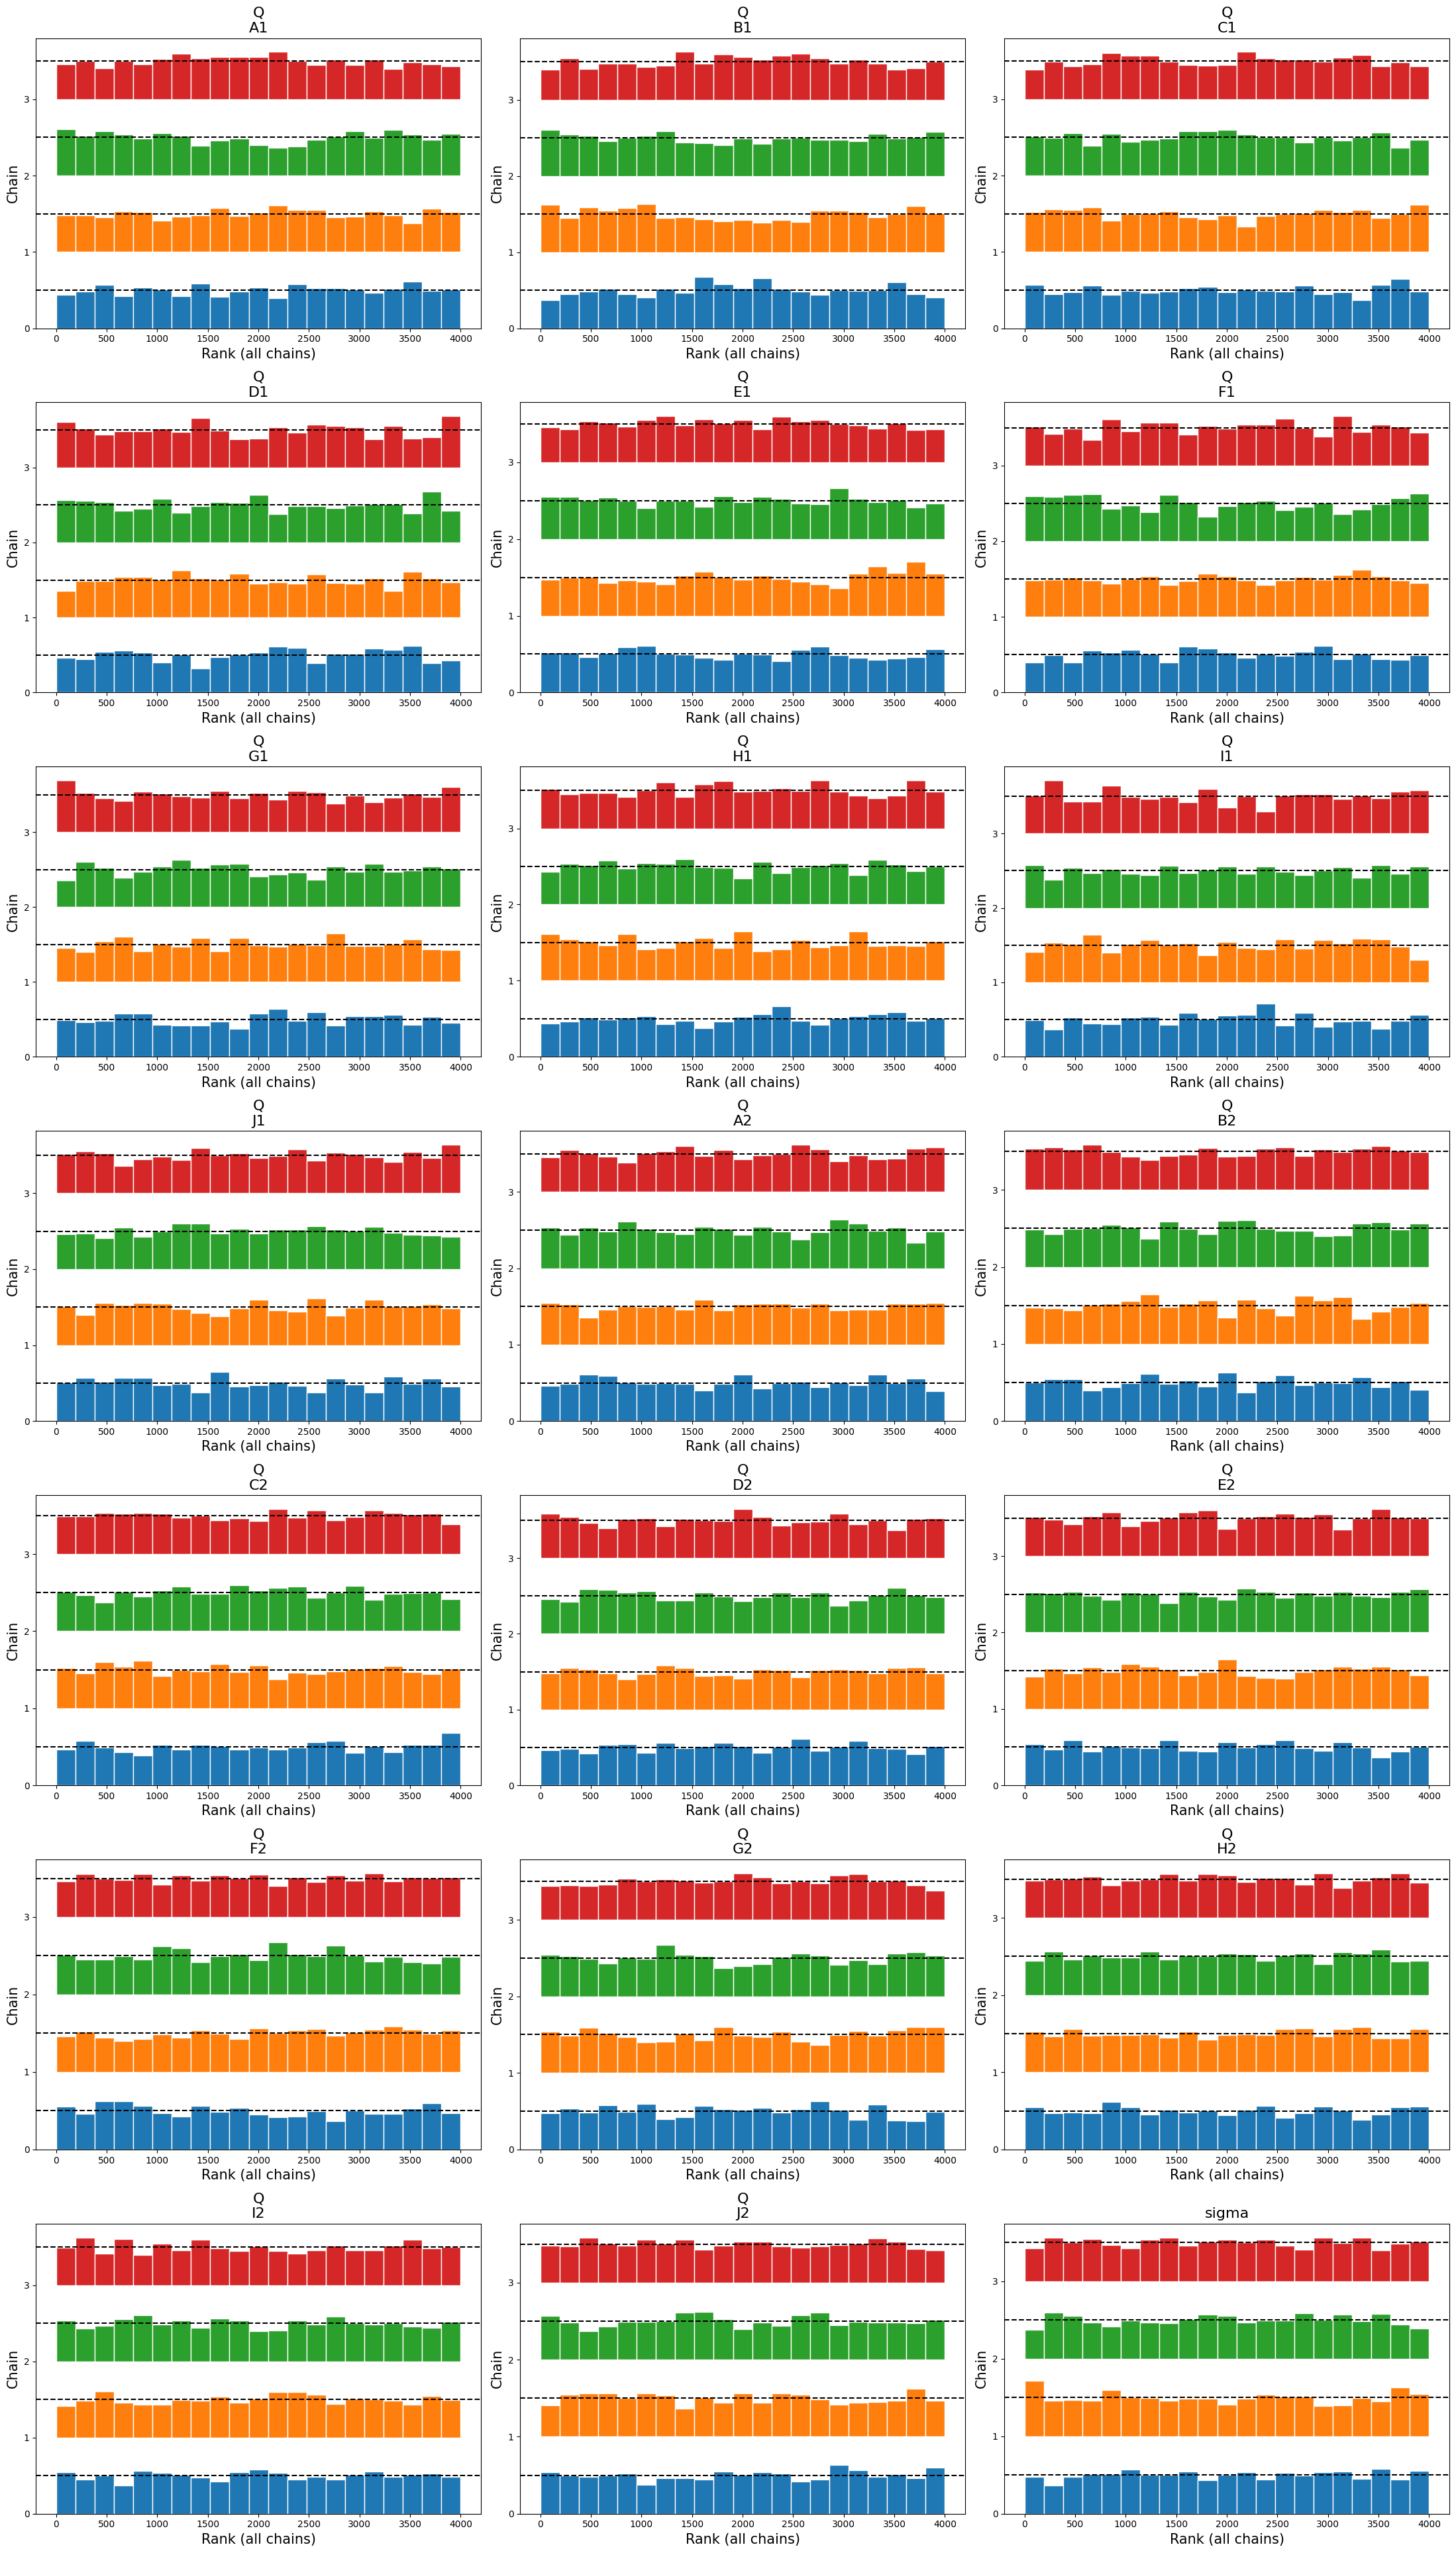

In [50]:
az.plot_rank(simple_inference); plt.tight_layout()

 Having all Trank plots associated with each chain hovering over around the average (dotted lines) is indicative of a set of well-mixed, efficient, Markov chains.

#### 3. R-hat
- Chain-convergence metric
- The variance ratio comparing within-chain variance to across-chain variance
- Similar (opposite) to metrics used to train k-means
- Idea is that if chains have converged, and are exploring the same space, then their within-chain variance should be more-or-less the same as the acorss-chain variance, providing an R-hat near 1.0
- No guarantees. This IS NOT A TEST.
  - no magical values; but be wary of values over 1.1 or so 🤷‍♂️. Maybe run the chains longer.

#### 4. Effective Sample Size (ESS)
- the are `ess_*`, where `tail` and `bulk` are different methods for estimating the effective samples
- `tail` seems to give ESS samples after burnin
- idea is to get an estimate of the number of samples available that are close to being independent to one another
- tends to be smaller than the number of actual samples run (because actual samples aren't actually independent in real world)

#### Diagnostics (3 and 4)

In [51]:
az.summary(simple_inference)[['ess_bulk', 'ess_tail', 'r_hat']]

ess_bulk  ess_tail  r_hat
Q[A1]    8188.0    2651.0   1.00
Q[B1]   10104.0    3006.0   1.01
Q[C1]   10052.0    2791.0   1.00
Q[D1]    8523.0    2756.0   1.00
Q[E1]    8002.0    2789.0   1.00
Q[F1]    9058.0    3050.0   1.00
Q[G1]    9482.0    3030.0   1.00
Q[H1]   10259.0    2990.0   1.00
Q[I1]   10755.0    3147.0   1.00
Q[J1]    8492.0    2905.0   1.00
Q[A2]    8240.0    2546.0   1.00
Q[B2]    9100.0    2760.0   1.00
Q[C2]    8849.0    2853.0   1.00
Q[D2]    9569.0    2980.0   1.00
Q[E2]    9209.0    3044.0   1.00
Q[F2]   10345.0    2883.0   1.00
Q[G2]    8765.0    3181.0   1.00
Q[H2]    8613.0    3148.0   1.00
Q[I2]    8947.0    2829.0   1.00
Q[J2]    8520.0    3276.0   1.00
sigma    6415.0    3089.0   1.00

##### ESS Evolution Plot
- For Markov Chains that are converging, ESS should increase consistently with the number of draws from the chain
- ESS vs draws should be roughly linear for both `bulk` and `tail`

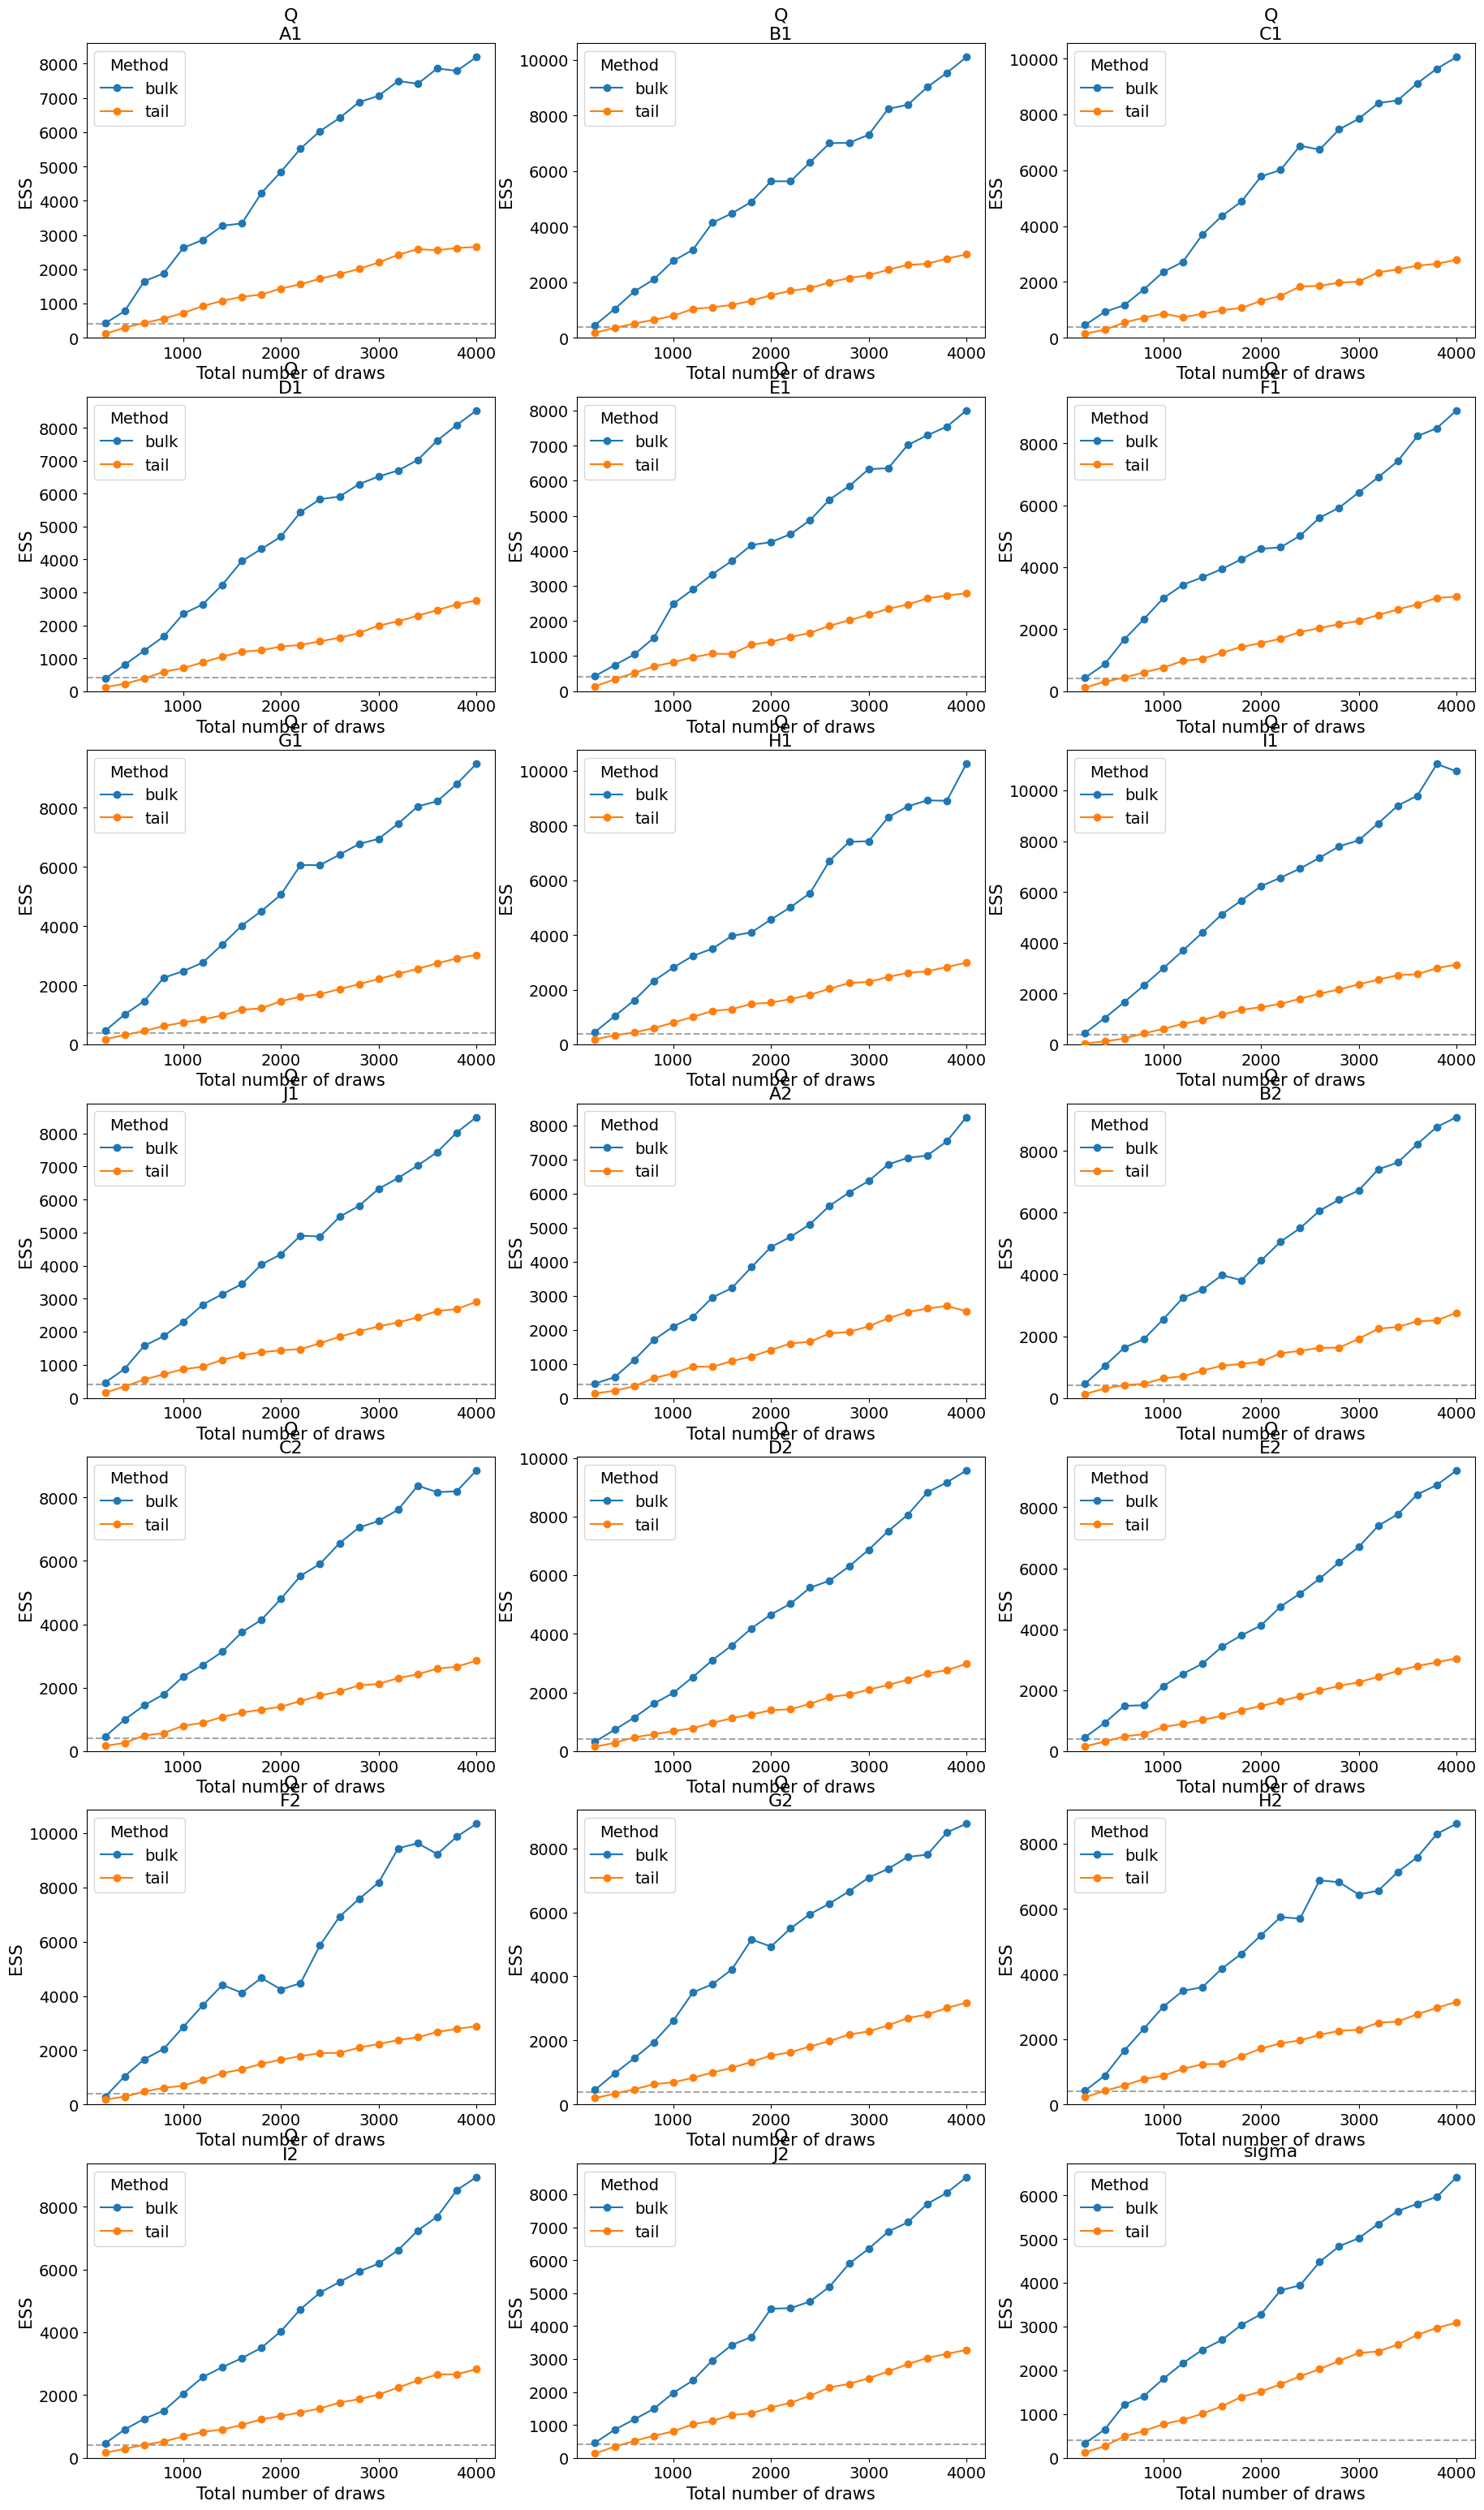

In [52]:
az.plot_ess(simple_inference, kind='evolution');

## More complete model, stratify by Wine Origin, $O_{X[i]}$

$$
\begin{align*}
S_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= Q_{W[i]} + O_{X[i]}\\
Q_{W[i]} &\sim \text{Normal}(0, 1) \\
O_{X[i]} &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$



In [53]:
WINE

Index(['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'A2', 'B2',
       'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'J2'],
      dtype='object')

In [57]:
with pm.Model(coords={"wine": WINE, "wine_origin": WINE_ORIGIN}) as wine_origin_model:
    sigma = pm.Exponential("sigma", 1)
    O = pm.Normal("Origin", 0, 1, dims="wine_origin")
    Q = pm.Normal("Quality", 0,1, dims="wine")
    mu  = Q[WINE_ID] + O[WINE_ORIGIN_ID]
    
    S = pm.Normal("Score", mu, sigma, observed = SCORES)
    
    wine_origin_inference = pm.sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Origin, Quality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


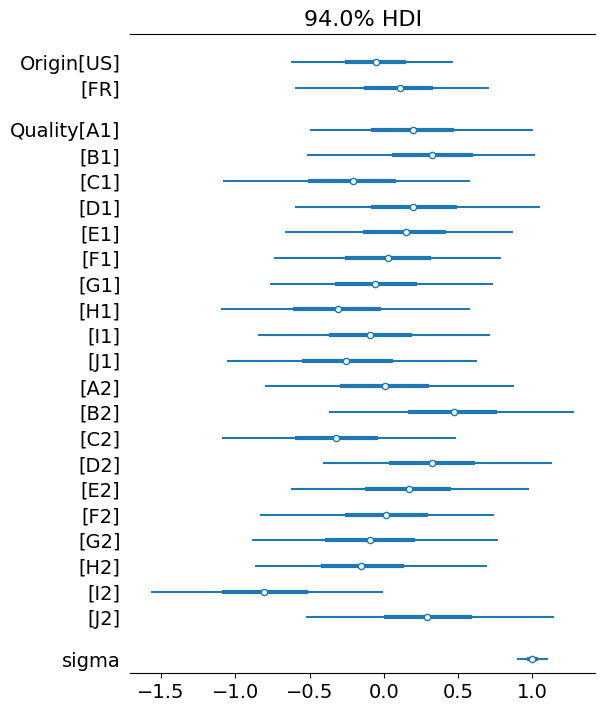

In [58]:
az.plot_forest(wine_origin_inference, combined=True);

## Including Judge Effects

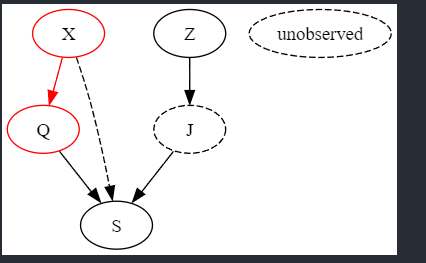

- Looking at the DAG (above), we see that judges descrimination is a competing cause of the measured score. 
- We indclude Judge effects using an **Item Response-type model** for the mean score: $\mu_i = (Q_{W[i]} + O_{X[i]} - H_{J[i]})D_{J[i]}$
- where the mean $\mu_i$ of the score $S_i$ is modeled as a linear combination of
  - wine quality $Q_{W[i]}$
  - wine origin $O_{X[i[}$
  - judge's baseline scoring harshness $H_{J[i]}$
    - values $< 0$ indicates a judge is less likely than average to judge a wine badly
  - all of this is modulated (multiplied) by the judge's discrimination ability $D_{J[i]}$
    - a value $> 1$ indicates a judge provides larger scores discrepancies for differences in wine
    - a value $< 1$ indicates a judge gives smaller scores discrepancies for differences in wine
    - a value of 0 indicates a judge gives all wines an average score
   

#### Statistical model
$$
\begin{align*}
S_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= (Q_{W[i]} + O_{X[i]} - H_{J[i]})D_{J[i]} \\
Q_{W[i]} &\sim \text{Normal}(0, 1) \\
O_{X[i]} &\sim \text{Normal}(0, 1) \\
H_{X[i]} &\sim \text{Normal}(0, 1) \\
D_{X[i]} &\sim \text{Exponential}(1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$



In [59]:
with pm.Model(coords={"wine": WINE, "wine_origin": WINE_ORIGIN, "judge": JUDGE}) as judges_model:
    
    # Judge effects
    D = pm.Exponential("D", 1, dims='judge')  # Judge Discrimination (multiplicative)
    H = pm.Normal("H", 0, 1, dims='judge')    # Judge Harshness (additive)
    
    # Wine Origin effect
    O = pm.Normal("O", 0, 1, dims="wine_origin")
    
    # Wine Quality effect
    Q = pm.Normal("Q", 0, 1, dims="wine")
    
    # Score
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    mu = (O[WINE_ORIGIN_ID] + Q[WINE_ID] - H[JUDGE_ID]) * D[JUDGE_ID]
    S = pm.Normal("S", mu, sigma, observed=SCORES)
    
    judges_inference = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D, H, O, Q, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


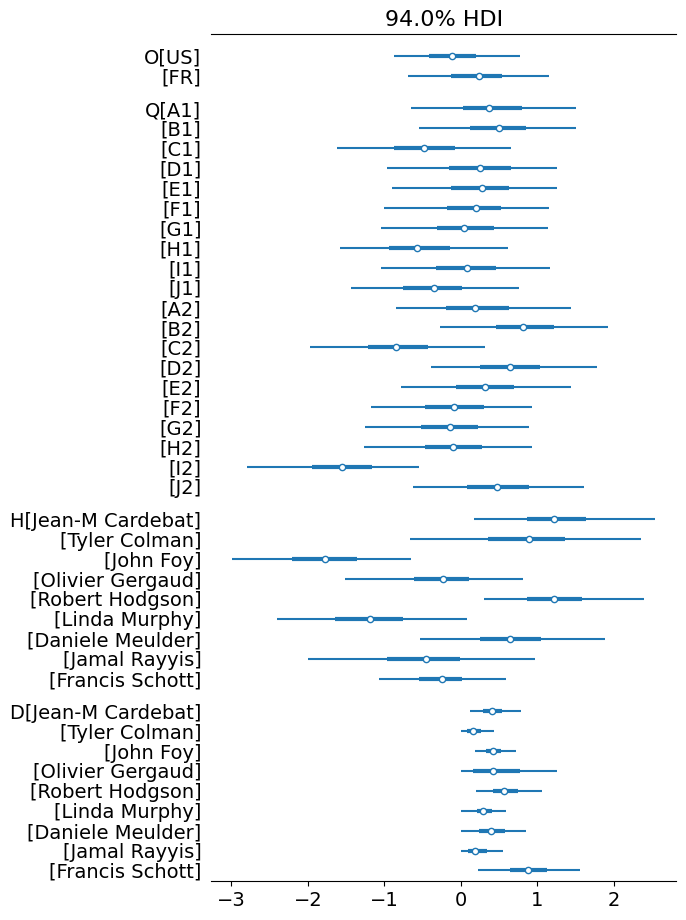

In [60]:
az.plot_forest(judges_inference, var_names=['O', 'Q', 'H', 'D'], combined=True);

## Does Wine Origin Matter?

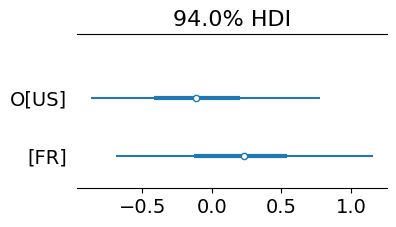

In [61]:
_, ax = plt.subplots(figsize=(4, 2))
az.plot_forest(judges_inference, combined=True, var_names=['O'], ax=ax);

### Calculating the contrast distribution
#### Always be contrasting

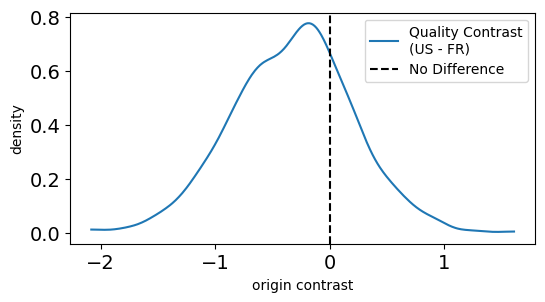

In [62]:
# Posterior contrast
plt.subplots(figsize=(6, 3))
quality_US = judges_inference.posterior.sel(wine_origin='US')
quality_FR = judges_inference.posterior.sel(wine_origin='FR')
contrast = quality_US - quality_FR

wine_origin_model_param = "O"

az.plot_dist(contrast[wine_origin_model_param], label='Quality Contrast\n(US - FR)')
plt.axvline(0, color='k', linestyle='--', label='No Difference')
plt.xlabel("origin contrast")
plt.ylabel("density")
plt.legend();

In [70]:
quality_US

<xarray.Dataset>
Dimensions:      (chain: 2, draw: 1000, judge: 9, wine: 20)
Coordinates:
  * chain        (chain) int32 0 1
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * judge        (judge) <U15 'Jean-M Cardebat' ... 'Francis Schott'
    wine_origin  <U2 'US'
  * wine         (wine) <U2 'A1' 'B1' 'C1' 'D1' 'E1' ... 'G2' 'H2' 'I2' 'J2'
Data variables:
    H            (chain, draw, judge) float64 1.864 1.211 ... -0.9278 -0.5771
    O            (chain, draw) float64 -0.004725 -0.3281 ... 0.05569 0.2182
    Q            (chain, draw, wine) float64 1.157 1.416 ... -1.904 0.2917
    D            (chain, draw, judge) float64 0.3095 0.2418 ... 0.175 0.6234
    sigma        (chain, draw) float64 0.8026 0.8359 0.8022 ... 0.893 0.8099
Attributes:
    created_at:                 2024-12-13T16:47:30.503392
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              30.387335300445557
    tuning_steps:               1000